# An Introduction to Neural Networks
# 02 - Singlelayer Perceptron

<p>
    Esse é o nosso primeiro tutorial realmente sobre Redes Neurais! Nesse tutorial, iremos estudar a Rede Neural de camada-única mais simples: a Singlelayer Perceptron. <br>Mais específicamente, iremos aprender como:
</p>
<ul>
    <li>Programar e avaliar funções básicas de Redes Neurais</li>
    <li>Desenvolver um algoritmo iterativo para treinar uma Rede Neural, adaptando seus pesos;</li>
    <li>Utilizar uma Rede Neural para realizar classificação binária em um dataset;</li>
    <li>Utilizar uma Rede Neural para realizar classificação multiclasse em um outro dataset;</li>
</ul>

### Bibliotecas, Variáveis Importantes e Funções Auxiliares

In [3]:
## BIBLIOTECAS ##
import pandas as pd                 # <-- Representação e Manipulação dos Dados
import numpy as np                  # <-- Biblioteca para Operações Matriciais e Complexas
import matplotlib.pyplot as plt     # <-- Biblioteca para Visualização de Dados

## VARIÁVEIS IMPORTANTES ##
colorpad = ["#d11141", "#00aedb", "#00b159", "#f37735", "#ffc425"]
colorpadBG = ["#00aedb50", "#d1114150", "#00b15950", "#f3773550", "#ffc42550"]

## FUNÇÕES AUXILIARES ##
# Plota um fundo colorido para as visualizações
def plotContour(X, model, theta, nClasses=2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model(np.c_[xx.ravel(), yy.ravel()], theta, False) 
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors="#2A2A2A", linewidths=2)
    plt.contourf(xx, yy, Z, levels=range(-1,nClasses), colors=colorpadBG)

    
# Essa linha abaixo é apenas para que os 
# plots sejam gerados na mesma célula do código
%matplotlib inline

### Datasets

<p>
    Neste tutorial, utilizaremos um dataset artificial, criado apenas para servir como base à explicação dos conceitos relacionados ao treino de Redes Neurais de camada-única. <br>
    
    O código abaixo já está pronto. Para mais detalhes sobre como resgatar e manipular dados de arquivos, refira-se ao Tutorial 01.
</p>

In [4]:
## CARREGANDO E PRÉ-PROCESSANDO OS DADOS ##
# Carregando os dados a partir do arquivo .csv
data = pd.read_csv("datasets/data_01.csv")

# Armazenando as dimensões dos dados
m = data.shape[0]
n = data.shape[1]-1

# Separação do Conjunto de Treino e Conjunto de Teste
trainingSize = int(0.8 * m)
indexes = np.random.randint(0, m, m)
trainData = data.iloc[indexes[:trainingSize]]
testData = data.iloc[indexes[trainingSize:]]

# Obtendo matrizes (formato Numpy) correspondentes
X_train = trainData.iloc[:,:-1].values
y_train = trainData.iloc[:, -1].values

X_test = testData.iloc[:,:-1].values
y_test = testData.iloc[:, -1].values

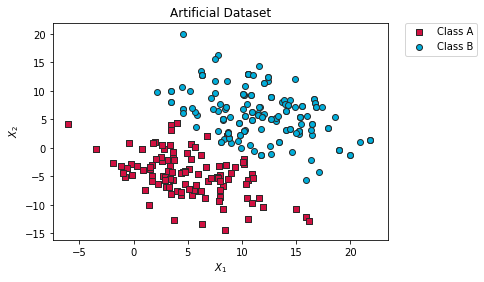

In [14]:
## VISUALIZAÇÃO CONDICIONADA COM O MATPLOTLIB E NUMPY ##
plt.figure()

a_class = np.where(y_train == "A")
b_class = np.where(y_train == "B")

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Parte 1 -  Funções Básicas de Redes Neurais

### A Função Sigmoid
<p>
    Como vimos, uma Rede Neural consiste num conjunto de <i>neurônios artificiais</i> interligados por "sinapses" que possuem pesos associados. Antes de desenvolvermos os algoritmos que ajustam automaticamente estes pesos, é necessário programar as funções básicas de ativação dos neurônios, e da Rede Neural inteira.<br><br>
    
    Lembre-se que um neurônio artificial realiza duas computações:
    <ul>
        <li>Soma ponderada dos sinais de entradas;</li>
        <li>Ativação (ou não) do sinal acumulado;</li>
    </ul>
    
    Primeiramente, iremos programar a nossa função de ativação como a sigmoide, representada por: <br> <br>
    
    $$
        \varphi(z) = \frac{1}{1 + e^{z}}
    $$ 
    <br>
    onde $z$ possa ser também um vetor (e nesse caso a função retorna também um vetor). <br><br>
</p>

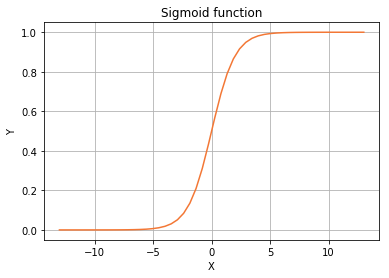

In [25]:
# Definição das Funções Sigmoide e Modelo Perceptron
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Teste da Sigmoide
dom = np.linspace(-13, 13)
sig = sigmoid(dom)

plt.figure()

plt.title("Sigmoid function"); plt.xlabel("X"); plt.ylabel("Y")
plt.plot(dom, sig, color=colorpad[3])
plt.grid()

plt.show()

### Função de Predição

<p>
    A segunda parte, então, consiste em fazer a função de "predição" da SLP, onde os sinais de entrada são ponderados e somados, e então aplicados à função de ativação. Faremos uma condição para que a ativação final possa ter duas formas: a de uma probabilidade (um número real entre 0 e 1) ou seja igual ao número da classe predita (um valor inteiro). <br> <br>
    
    Temos que: 
    $$
        S_\text{net} = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n y_n
    $$
    
    e
    
    $$
        \varphi(S_\text{net}) = \frac{1}{1 + e^{w_0 + w_1 x_1 + w_2 x_2 + ... + w_n y_n}}
    $$
    
    Lembramos que essa operação pode ser implementada apenas com operações matriciais, reduzindo bastante a complexidade do código. Tente imaginar como seriam essas computações! :)
</p>

In [24]:
# Função de Predição (Ativação) de uma SLP    
def slp_predict(X, theta, probs=True):
    if(X.shape[1] != theta.shape[1]): 
        X = np.hstack([np.ones([X.shape[0], 1]), X])

    predictions = sigmoid(np.matmul(X, theta.T))[:,0]
    
    if(probs):
        return predictions
    else:
        return (predictions >= 0.5)

# Teste da Ativação
theta = np.array([[4.5, 3, -2.5]])
X = np.array([[-2.7,  4.1],
              [   1,  3.1],
              [ 2.3,  4.0],
              [   0, -2.4]])

print("Probability format:\n", slp_predict(X, theta))
print()
print("Classification format:\n", slp_predict(X, theta, False).astype(int))

Probability format:
 [  9.66097606e-07   4.37823499e-01   8.02183889e-01   9.99972464e-01]

Classification format:
 [0 0 1 1]


### Função de Cálculo de Acurácia
Em problemas de Classificação, subtrair o valor previsto do valor real não nos dá uma informação muito precisa (sobre, por exemplo, a gravidade do erro). Para avaliar melhor a qualidade de um Treinamento de Classificação existem diversas medidas. Uma bem comum, e simples, consiste na acurácia: a quantidade de exemplos "corretamente classificados". Vamos definir essa porcentagem como sendo:
    $$
        Acc(\theta) = 100 \times (1 - \frac{1}{m} \sum (h(\theta) - y)^{2}) 
    $$

Obs.: a acurácia só será correta caso tanto $h(\theta)$ quanto $y$ sejam valores binários. Logo, iremos arredondar os resultados de $h(\theta)$ utilizando a função Predict().

In [28]:
def accuracyFunction(X, y, theta):
    ''' Calculates the percentage of correct classifications '''
    Y_pred = slp_predict(X, theta, True)
    
    return 100 * (1 - (1 / np.size(y)) * np.sum((Y_pred - y) ** 2))

## Parte 2 - Treinando a Rede Neural

### Gradient Descendente
<p>
O algoritmo mais popular e simples para treinar automaticamente os parâmetros de uma Rede Neural consiste no Gradient Descendente. Para cada época até a convergência (ou até atingir o limite máximo definido pelo hiperparâmetro) iremos realizar o Treinamento do Single-Layer Perceptron. Os passos serão os seguintes:
</p>
<ul>
    <li>Calculamos o vetor de predição "predictions", como resultado da predição do Modelo para os parâmetros daquela época;</li>
    <li>Utilizando "predictions", calculamos os erros de acordo com o a matriz real "y";</li>
    <li>Concatenamos o Custo Total do erro calculado no Histórico de Erros;</li>
    <li>Realizamos, para cada parâmetro, o "passo do gradiente" para estimar os novos valores dos parâmetros;</li>
    <li>Imprimimos os resultados do treino a cada 50 épocas;</li>
    <li>Verificamos uma possível convergência do treino, e paremos o mesmo caso seja verificado;</li>
</ul>


In [99]:
###############################
#    SLP Training Function    #
###############################
def slp_train(X, y, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=False):
    # Define the data parameters
    m = X.shape[0]; n = X.shape[1]
    
    # Define the training parameters
    errorHist = []
    previousMSE = 0
    it = 1;
    
    # Stacks the bias column in the input data
    X = np.hstack([np.ones([m,1]), X])
    
    # Create the SLP weight matrix
    theta = np.random.randn(1, n+1)
    
    # Perform Gradient Descent
    while(it <= maxIt):
        # Calculate the current predictions and supervisioned error
        predicts = slp_predict(X, theta)
        error = predicts - (y == "A")
        
        # Calculate the MSE Error and appends to the history
        actualMSE = np.sum(error ** 2)
        actualAcc = accuracyFunction(X,(y == "A"),theta)
        errorHist.append(actualMSE)

        # Perform the gradient step
        for j in range(0,n):
            for k in range(0,m):
                theta[0,j] = theta[0,j] - (alpha/m) * (error[k] * X[k,j])
        
        # Vectorized form: theta -= (alpha/m) * (np.matmul(X.T, error))
        
        # Prints the training results after 50 epochs
        if(it % 50 == 0 and verbose): 
            print("## Iteration", it, "##")
            print("Error: ", actualMSE)
            print("Accuracy: ", actualAcc)
            print("Thetas: ", theta)
            print("\n")
        
        # Prints the training results if converge
        if(abs(actualMSE - previousMSE) <= tol):
            print("## Iteration", it, "##")
            print("!!! Convergence reached !!!")
            print("Error: ", actualMSE)
            print("Accuracy: ", actualAcc)
            print("Thetas: ", theta)
            print("\n")
            break;
            
        # Update some training variables
        previousMSE = actualMSE
        it +=1
    
    # End of the training
    return (theta, errorHist)

## Part 3 - Binary Classification with SLP

### Execução de Treinamento
<p>
Nessa secção avaliamos os resultados das funções de treinamento definidas e implementadas anteriormentes. É altamente recomendável que você "brinque" com os parâmetros da função <i>slp_train(.)</i> para entender melhor o funcionamento dos algoritmos de treino
</p>

In [108]:
[theta, errorHist] = slp_train(X_train, y_train, alpha=0.1)

## Iteration 40158 ##
!!! Convergence reached !!!
Error:  2.62211753556
Accuracy:  99.1805882701
Thetas:  [[ 14.03300672  -1.5646977   -1.46881404]]




### Visualizaçoes dos Resultados do Treino


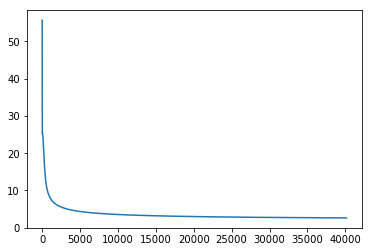

In [110]:
plt.figure()
plt.plot(errorHist)
plt.show()

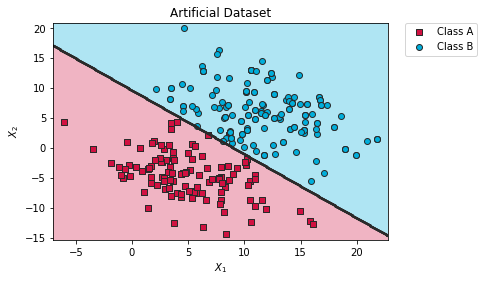

In [111]:
## VISUALIZAÇÃO DA CLASSIFICAÇÃO ##
plt.figure()

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plotContour(X_train, slp_predict, theta)

a_class = np.where(y_train == "A")
b_class = np.where(y_train == "B")

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()